# Outlier detection

In [ ]:
import numpy as np
import heapq as hq
import time
import matplotlib.pyplot as plt

## Generate data

To generate some data with outliers for this assignment, we're going to sample some data from a
distribution with known parameters, modify the parameters, and continue sampling to generate
some outliers.  In particular, we'll sample our data from a
[multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) by using [numpy.random.multivariate_normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.multivariate_normal.html) method.

Run the following cell to define a function to generate input data with specified number of dimensions.

In [ ]:
def generate_data(dim, num_initial_points):

    """
    Input: Integer dim is the dimensionality of the data to generate,
    integer num_initial_points is the number of original data points to generate.

    Action: Generate some data with some outliers.
    Start with generating num_initial_points data points by sampling from a multivariate normal distribution.
    Then, iteratively add more data points to generate some outliers.

    Output: Numpy array with dim dimensions
    """

    np.random.seed(10)

    # Create covariance matrix & mean vector
    mean = np.zeros(dim)
    covar = np.zeros((dim,dim))
    np.fill_diagonal(covar, 1)

    # Sample num_initial_points data points
    # from multivariate normal distribution
    # with pre-defined mean and covariance
    all_data = np.random.multivariate_normal(mean, covar, num_initial_points)

    # Start adding more data points to all_data to generate some outliers
    for i in range (10):
        mean.fill(2*i+5)
        more_data = np.random.multivariate_normal (mean, covar, (i+1)**2)
        all_data = np.concatenate ((all_data, more_data))
    return all_data

Let's visualize 2 dimensional data generated by `generate_data()`.

In [ ]:
data_2d = generate_data(2, 3000)

On the generated data, row indices up to 3000 belong to initial data points, and the rest of data points are extra data added iteratively to generate outliers.   

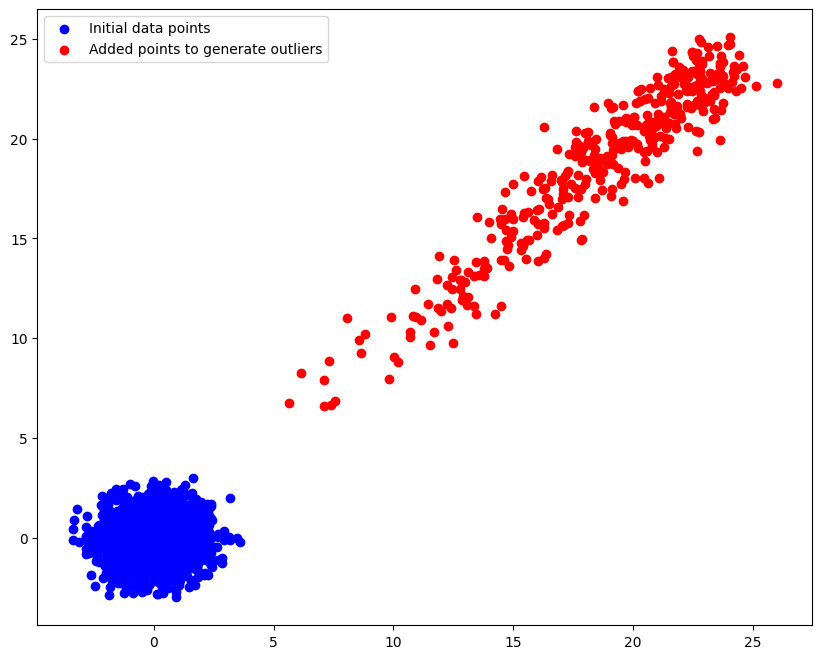

In [ ]:
fig, axs = plt.subplots(figsize=(10,8))
axs.scatter(data_2d[:3000,0], data_2d[:3000,1], c='b', label='Initial data points')
axs.scatter(data_2d[3000:,0], data_2d[3000:,1], c='r', label='Added points to generate outliers')
axs.legend()

For this assignment, we generate data with 100 dimensionality and with 3000 initial data points.

In [ ]:
data_100d = generate_data(100, 3000)

**Expected Output**

Based on our provided code to generate data, we generate growing batches of points clustered around increasing means. The most outlierly points will start at index `num_initial_points`.

## Task 1 - slow algorithm

The first part of this assignmentis to complete the function below by implementing the slow algorithm of outlier detection described in the lecture.



To implement the priority queue, use Python's [heapq](https://docs.python.org/3/library/heapq.html). Recall the first assignment in the course where we learned to use heapq for determining both min and maximum values. The distance between data points will be implemented using Euclidean distance (the l2-norm).

Note that the numpy function np.linalg.norm computes the L2 norm of a vector. You can call it with the **difference** of two point vectors to get the distance. See the documentation here: [np.linalg.norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)


In [ ]:
def get_outliers_slow(data, k=10, num_outliers=5):

    """
    Input: Numpy array data, interger k is the kth nearest neighbor to consider,
    integer num_outliers is the number of outliers we are looking for

    Action: Implement the slower algorithm of finding distance-based outliers

    Output: List of outliers (built as priority queue) with num_outliers entries;
    entries are (key, value) tuples,
    key is the Euclidean distance between the outlier and its kth nearest neighbor,
    value is the index of the outlier point in the input data
    """

    # Priority Queue for the outliers
    # Entries of this queue must be tuples of (key, value)
    # Keys are Euclidean distances
    # Values are indices of data points
    outliers = []
    hq.heapify(outliers)

    for i in range(len(data)): # for every x
      x1 = data[i]
      tmpq = []
      hq.heapify(tmpq) # max queue Q created
      for x2 in data:
        if np.array_equal(x1, x2): continue # x1 != x2
        hq.heappush(tmpq, -1*np.linalg.norm(x1-x2)) # insert distance into Q
        if len(tmpq) > k:
          hq.heappop(tmpq) # remove max from Q
      hq.heappush(outliers, (-1*hq.heappop(tmpq),i)) # insert to outlier
      if len(outliers) > num_outliers:
        hq.heappop(outliers) # remove min from O

    return outliers

In [ ]:
start_time = time.time()
outliers_slow = get_outliers_slow(data_100d)
end_time = time.time()

In [ ]:
print("Here is the list of detected outliers:")
outliers_slow

Here is the list of detected outliers:


[(23.72374367892497, 3003),
 (25.340148860874006, 3001),
 (25.459569062524572, 3004),
 (25.518460762934513, 3002),
 (41.829599159195396, 3000)]

In [ ]:
print("Run time of the slow algorithm of outlier detection = ", end_time-start_time, "(sec)")

Run time of the slow algorithm of outlier detection =  173.10876727104187 (sec)


## Task 2 - faster algorithm
The second part of this assignment is to complete the function below by implementing the fast algorithm of outlier detection described in the lecture.




In [ ]:
def get_outliers_fast(data, k=10, num_outliers=5):
    """
    Input: Numpy array data, interger k is the kth nearest neighbor to consider,
    integer num_outliers is the number of outliers we are looking for

    Action: Implement the faster algorithm of finding distance-based outliers

    Output: List of outliers (built as priority queue) with num_outliers entries;
    entries are (key, value) tuples,
    key is the Euclidean distance between the outlier and its kth nearest neighbor,
    value is the index of the outlier point in the input data
    """

    # Priority Queue for the outliers
    # Entries of this queue must be tuples of (key, value)
    # Keys are Euclidean distances
    # Values are indices of data points
    outliers = []
    hq.heapify(outliers)

    for i in range(len(data)): # for every x
      x1 = data[i]
      tmpq = []
      hq.heapify(tmpq) # max queue Q created
      dis = False # not discard at first
      for x2 in data:
        if np.array_equal(x1, x2): continue # x1 != x2
        hq.heappush(tmpq, -1*np.linalg.norm(x1-x2)) # insert distance into Q
        if len(tmpq) > k:
          hq.heappop(tmpq) # remove max from Q
        if len(tmpq) == k and len(outliers) == num_outliers and -hq.nsmallest(1,tmpq)[0]<hq.nsmallest(1,outliers)[0][0]:
          dis = True # discard then
          break
      if dis: continue
      hq.heappush(outliers, (-1*hq.heappop(tmpq),i)) # insert to outlier
      if len(outliers) > num_outliers:
        hq.heappop(outliers) # remove min from O

    return outliers

In [ ]:
start_time = time.time()
outliers_fast = get_outliers_fast(data_100d)
end_time = time.time()

In [ ]:
print("Here is the list of detected outliers:")
outliers_fast

Here is the list of detected outliers:


[(23.72374367892497, 3003),
 (25.340148860874006, 3001),
 (25.459569062524572, 3004),
 (25.518460762934513, 3002),
 (41.829599159195396, 3000)]

In [ ]:
print("Run time of the fast algorithm of outlier detection = ", end_time-start_time, "(sec)")

Run time of the fast algorithm of outlier detection =  36.15928316116333 (sec)


## Shuffling data to run even faster!

If we shuffle data to store data points in a randomized order of indices, we can get even run our fast algorithm faster!

In [ ]:
np.random.seed(10)
# Note that this code shuffles the contents of data_100d in-place.
np.random.shuffle(data_100d)

In [ ]:
start_time = time.time()
outliers_fast_shuffled = get_outliers_fast(data_100d)
end_time = time.time()

In [ ]:
print("Here is the list of detected outliers:")
outliers_fast_shuffled

Here is the list of detected outliers:


[(23.72374367892497, 1599),
 (25.340148860874006, 1262),
 (41.829599159195396, 1973),
 (25.518460762934513, 87),
 (25.459569062524572, 870)]

In [ ]:
print("Run time of the faster algorithm of outlier detection = ", end_time-start_time, "(sec)")

Run time of the faster algorithm of outlier detection =  10.012789249420166 (sec)
